# LipNet Project #

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as pd
from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
def PRINT(text) -> None: print(f"{80*'-'}\n{text}\n{80*'-'}")

## Load Data ##

In [4]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'

gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [69]:
def load_video(path: str) -> tf.Tensor:
    """
    Load a video from the specified path, extract lip regions from each frame,
    and return processed frames as a TensorFlow tensor.

    Parameters:
    - path (str): The path to the video file.

    Returns:
    - tf.Tensor: Processed frames as a TensorFlow tensor.

    Raises:
    - ValueError: If there is an error opening the video file.
    """
    
    cap = cv2.VideoCapture(path)
    frames = []

    if not cap.isOpened():
        raise ValueError(f"Error opening video file: {path}")

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Convert to grayscale using OpenCV
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Extract and resize the ROI
            lips_roi = frame_gray[190:236, 80:220]

            frames.append(lips_roi)
    finally:
        cap.release()

    # convert list of NumPy array into TensorFlow tensor
    frames = tf.convert_to_tensor(frames, dtype=tf.float32)
    
    # Apply batch normalization
    frames = (frames - tf.reduce_mean(frames)) / tf.math.reduce_std(frames)

    return frames


In [23]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [24]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [13]:
def load_alignments(path: str) -> List[str]:
    """
    Load alignments from the specified file, filter non-silence tokens, 
    convert to numerical format and return the sequence.

    Parameters:
    - path (str): The path to the alignments file.

    Returns:
    - List[str]: Numerical sequence of non-silence tokens.

    If an error occurs during loading or processing, an exception is caught and an error message is printed, and the function returns None.
    """
    
    try:
        with open(path, 'r') as f:
            lines = f.readlines()

        # Filter and extract non-silence tokens
        tokens = [' ' + line.split()[2] for line in lines if line.split()[2] != 'sil']

        # Convert to numerical format using char_to_num
        numerical_sequence = char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

        return numerical_sequence

    except Exception as e:
        print(f"Error loading alignments from {path}: {e}")
        return


In [12]:
def load_data(path:str):
    
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments
    

In [58]:
pwd

'C:\\Users\\gavvi\\Desktop\\Programming\\GitHub\\Computer Vision Projects\\Lip Read Project'

In [59]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


(-0.5, 139.5, 45.5, -0.5)

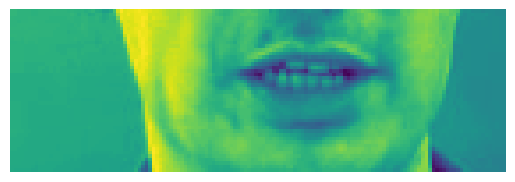

In [68]:
plt.imshow(frames[41])
plt.axis(False)

In [71]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [72]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [10]:
def mappable_function(path:str) ->List[str]:
    """
    Description:
    This TensorFlow function, mappable_function, utilizes tf.py_function
    to create a TensorFlow operation. It calls the load_data function with
    the input path and specifies that the result should have data types
    tf.float32 and tf.int64. The function returns the result of the
    py_function operation.

    Parameters:
    - path (str): The path used as input for the load_data function.

    Returns:
    List[str]: The result of the py_function operation, with data types
    tf.float32 and tf.int64.
    """
    
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## Data Pipeline ##

Pipeline for processing a list of video files. Include listing the files, shuffling them, applying a mapping function, creating padded batches, and prefetching data for improved performance during training.

In [14]:
# Listing Files: Create a TensorFlow dataset with file paths matching the specified pattern.
data = tf.data.Dataset.list_files('./data/s1/*.mpg')

# Shuffling the Data: Randomize the order of elements in the dataset.
data = data.shuffle(buffer_size=500, reshuffle_each_iteration=False)

# Mapping a Function: Apply the mappable_function to each element of the dataset.
data = data.map(mappable_function)

# Padded Batching: Create batches of size 2 and pad elements to the specified shape.
data = data.padded_batch(2, padded_shapes=([75,None,None],[40]))

# Prefetching Data: Prefetch elements from the input dataset for improved performance.
data = data.prefetch(tf.data.AUTOTUNE)


In [15]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [112]:
frames, alignments = data.as_numpy_iterator().next()

In [113]:
alignments

array([[ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  2, 25, 39,  1, 39, 19,
         5, 22,  5, 14, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39,  7, 18,  5,  5, 14, 39,  1, 20, 39, 14, 39,  6,
         9, 22,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)

(-0.5, 139.5, 45.5, -0.5)

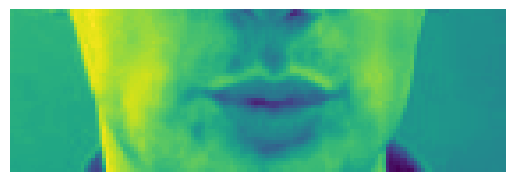

In [122]:
plt.imshow(frames[1][40])
plt.axis(False)

In [16]:
train = data.take(450)
test = data.skip(450)

In [17]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [123]:
gif_test = data.as_numpy_iterator().next()

In [125]:
imageio.mimsave('./animation.gif', gif_test[0][1], fps=10)

Lossy conversion from float32 to uint8. Range [-4.828561305999756, 2.691601276397705]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.6989030838012695, 2.6051626205444336]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.655683994293213, 2.6483819484710693]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.655683994293213, 2.6051626205444336]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.655683994293213, 2.6483819484710693]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.612464427947998, 2.6483819484710693]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-4.655683994293213, 2.7348206043243

--------------------------------------------------------------------------------
First video annotation from the current batch:

b'place white at d three soon'
--------------------------------------------------------------------------------


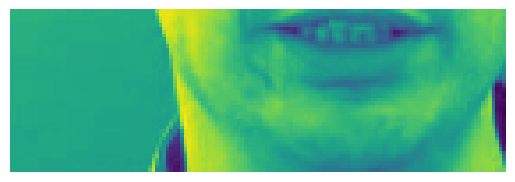

In [153]:
plt.imshow(gif_test[0][1][51])
plt.axis(False)

PRINT(f'First video annotation from the current batch:\n\n{tf.strings.reduce_join([num_to_char(word) for word in gif_test[1][0]])}')

## Design the Deep Nueral Net - LipNet ##

### Import Libraries ###

We bring in TensorFlow and Keras to craft our neural network. Sequential guides our layer arrangement, including Conv3D, LSTM, Dense, and more. Adam optimizes, ModelCheckpoint saves, and LearningRateScheduler adjusts—forming a powerful toolkit for our deep learning adventure.



In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [25]:
class LipNet:
    
    def __init__(self, input_shape=(75,46,140,1)):
        self.__model = self.build_model(input_shape)
        
    def build_model(self, input_shape_):
        
        self.__model = Sequential()
        
        self.__model.add(Conv3D(128, 3, input_shape=input_shape_, padding='same'))
        self.__model.add(Activation('relu'))
        self.__model.add(MaxPool3D((1,2,2)))
        
        self.__model.add(Conv3D(75, 3, input_shape=input_shape_, padding='same'))
        self.__model.add(Activation('relu'))
        self.__model.add(MaxPool3D((1,2,2)))
        
        self.__model.add(TimeDistributed(Flatten()))
        
        self.__model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', 
                                     return_sequences=True)))
        self.__model.add(Dropout(0.5))
        
        self.__model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', 
                                     return_sequences=True)))
        self.__model.add(Dropout(0.5))
        
        self.__model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
        
        return self.__model
    
    def compile_model(self):
        self.__model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss=CTCLoss)
    
    def get_model(self):
        return self.__model
    
    def summerize_model(self):
        self.__model.summary()
        
    

In [31]:
LipNet_instance = LipNet()
LipNet_instance.summerize_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_6 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 75, 23, 70, 75)    259275    
                                                                 
 activation_7 (Activation)   (None, 75, 23, 70, 75)    0         
                                                      

## Setup Training Options ##

In [1]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [6]:
def CTCLoss(y_true, y_pred):
    
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    
    return loss

In [8]:
class ProduceExample(tf.keras.callbacks.Callback):
    
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()
        
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('¬'*100)


In [33]:
LipNet_instance.compile_model()

In [34]:
model = LipNet_instance.get_model()

In [35]:
model

### Generate Callbacks ###

In [36]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [37]:
schedule_callback = LearningRateScheduler(scheduler)

In [39]:
example_callback = ProduceExample(test)